In [1]:
import bt
import FinanceDataReader as fdr
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantstats as qs
import seaborn as sns

# pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot') #ggplot
plt.rcParams['font.family'] = 'nanummyeongjo'
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.formatter.useoffset'] = False
# plt.rcParmas['axes.formatter.limits'] = -1000, 1000

plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from IPython.display import display, HTML
"%config InlineBackend.figure_format = 'retina'"

#하나의 cell에서 multiple output을 출력을 가능하게 하는 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Pandas Dataframe의 사이즈가 큰 경우, 어떻게 화면에 출력을 할지를 세팅하는 코드
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('max_columns', None)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from strategy import*
from utils import *

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [4]:
prices = pd.read_csv('data/assets.csv', index_col=0, parse_dates=True)

https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1086

주기를 월로 해서 다운로드한다. (2001년 1월~)

보유금액 > 유가증권시장 사용

(1) 한달 lag(shift(1)) 한다.
 - 1월의 데이터가 1월 마지막날 데이터이고 2월 1일 리밸런싱시에 사용하기

In [5]:
외국인수급 = pd.read_csv('data/외국인수급.csv') 
외국인수급 = 외국인수급.set_index('Date').T 
외국인수급.index = pd.to_datetime(외국인수급.index, format="%Y%m월")
# 외국인수급 =
# 외국인수급.resample('D').first().fillna(method='ffill')[['유가증권시장']]
외국인수급 = 외국인수급[['유가증권시장']] 
외국인수급.columns = ['kospi']
외국인수급['kospi'] = 외국인수급['kospi'].astype('float') 
외국인수급 = 외국인수급.shift(1) # --- (1)
외국인수급

,kospi
2001-01-01,nan
2001-02-01,81.800
2001-03-01,76.000
2001-04-01,70.700
2001-05-01,80.700
...,...
2021-04-01,766.500
2021-05-01,783.000
2021-06-01,779.400
2021-07-01,799.500


In [6]:
외국인수급['1m'] = 외국인수급['kospi'].pct_change(1) 
외국인수급['2m'] = 외국인수급['kospi'].pct_change(1).shift(1) 
외국인수급['3m'] = 외국인수급['kospi'].pct_change(1).shift(2) 
외국인수급

,kospi,1m,2m,3m
2001-01-01,nan,nan,nan,nan
2001-02-01,81.800,nan,nan,nan
2001-03-01,76.000,-0.071,nan,nan
2001-04-01,70.700,-0.070,-0.071,nan
2001-05-01,80.700,0.141,-0.070,-0.071
...,...,...,...,...
2021-04-01,766.500,0.008,0.014,0.037
2021-05-01,783.000,0.022,0.008,0.014
2021-06-01,779.400,-0.005,0.022,0.008
2021-07-01,799.500,0.026,-0.005,0.022


 >외국인 코스피 수급을 이용하여 직전 3개월 **연속** 상승시 100%, 2개월 연속 상승시 66%, 1개월 연속 상승시 33% 비중으로 스위칭

블로그 문서대로 라면 아래처럼 계산해야 한다.

In [7]:
연속3개월 = ((외국인수급['3m'] > 0) & (외국인수급['2m'] > 0) & (외국인수급['1m'] > 0)) 
연속2개월 = ((외국인수급['2m'] > 0) &(외국인수급['1m'] > 0)) 
연속1개월 = (외국인수급['1m'] > 0)
target_weights = pd.DataFrame(np.where(연속3개월, 1.0, 
                                np.where(연속2개월, 0.66, 
                                    np.where(연속1개월, 0.33, 0))),
                            index=외국인수급.index, 
                            columns=['ams']) 
target_weights.head(20)

,ams
2001-01-01,0.000
2001-02-01,0.000
2001-03-01,0.000
2001-04-01,0.000
2001-05-01,0.330
2001-06-01,0.660
2001-07-01,0.000
2001-08-01,0.000
2001-09-01,0.000
2001-10-01,0.000


위와 다른 방식으로는
3개월 연속 상승시 1점, 2개월 연속 상승시 1점, 1개월 상승시 1점을 주고 평균으로 비중을 구한다.

In [8]:
tw = pd.DataFrame(np.where((외국인수급['3m']>0) & (외국인수급['2m']>0) & (외국인수급['1m']>0), 1, 0), index=외국인수급.index, columns=['3m'])
tw['2m'] = np.where((외국인수급['2m']>0) & (외국인수급['1m']>0), 1, 0)
tw['1m'] = np.where(외국인수급['1m']>0, 1, 0) 
tw['ams'] = (tw['1m']+tw['2m']+tw['3m']) / 3 
tw.head(20)

,3m,2m,1m,ams
2001-01-01,0,0,0,0.000
2001-02-01,0,0,0,0.000
2001-03-01,0,0,0,0.000
2001-04-01,0,0,0,0.000
2001-05-01,0,0,1,0.333
2001-06-01,0,1,1,0.667
2001-07-01,0,0,0,0.000
2001-08-01,0,0,0,0.000
2001-09-01,0,0,0,0.000
2001-10-01,0,0,0,0.000


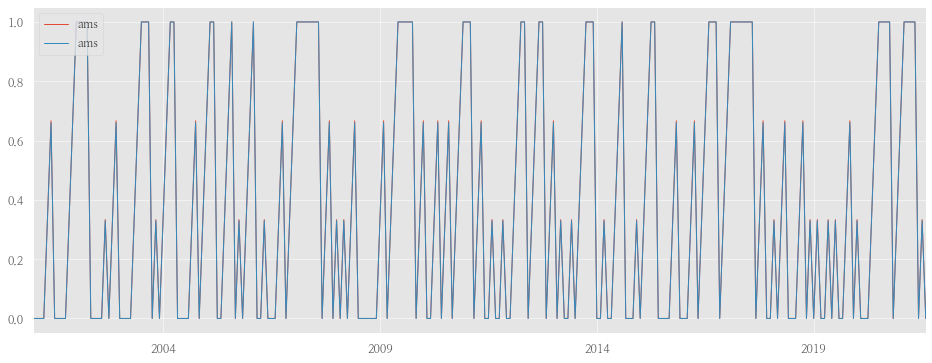

In [9]:
ax = tw['ams'].plot(figsize=(16,6)); target_weights.plot(ax=ax);
ax.legend(loc="upper left");

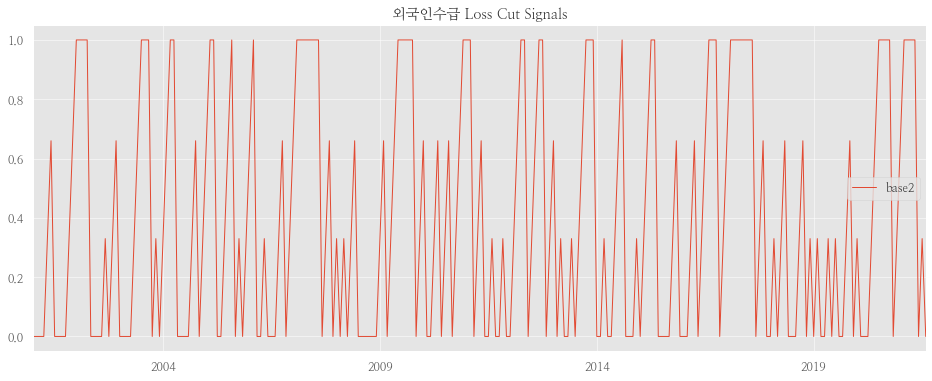

In [10]:
target_weights['현금'] = 1.0 - target_weights
target_weights.columns = ['base2', '현금'] 
# target_weights.to_csv('한국Base2비중.csv')
target_weights['base2'].plot(figsize=(16,6), title='외국인수급 Loss Cut Signals', legend=True);

In [11]:
tickers = list(prices.columns[:-4])+['현금'] 
print(tickers)

['MKF500', '에너지', '화학', '금속및광물', '기타 소재', '건설', '조선', '기타자본재', '상업서비스', '운송', '자동차및부품', '내구소비재및의류', '소비자서비스', '미디어', '유통', '음식료및담배', '생활용품', '의료', '은행', '보험', '증권', '기타금융', '소프트웨어', '하드웨어', '반도체', '디스플레이', '통신서비스', '유틸리티', '코스피200', '코스닥', '현금']


In [12]:
base2 = bt.Strategy(
    'base2', 
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(), bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0)),
        bt.algos.SelectN(n=2, sort_descending=True),
        # bt.algos.PrintDate(),
        bt.algos.WeighEqually(),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance() 
    ] 
)
# %%
bt_id2 = bt.Backtest(base2, prices) 
r_id2 = bt.run(bt_id2)

In [13]:
kbase2 = bt.Strategy(
    'kbase2',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=2, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)
# %%
bt_kbase2 = bt.Backtest(kbase2, prices) 
r = bt.run(bt_id2, bt_kbase2)

In [14]:
r.set_date_range("2002-02-01") 
r.display()

Stat                 base2       kbase2
-------------------  ----------  ----------
Start                2002-02-01  2002-02-01
End                  2020-07-02  2020-07-02
Risk-free rate       0.00%       0.00%

Total Return         794.20%     419.82%
Daily Sharpe         0.47        0.57
Daily Sortino        0.72        0.86
CAGR                 12.63%      9.36%
Max Drawdown         -63.15%     -28.82%
Calmar Ratio         0.20        0.32

MTD                  1.93%       1.94%
3m                   32.70%      10.20%
6m                   20.23%      11.05%
YTD                  19.82%      10.94%
1Y                   17.69%      9.32%
3Y (ann.)            -2.69%      -4.29%
5Y (ann.)            -1.38%      2.68%
10Y (ann.)           9.02%       7.88%
Since Incep. (ann.)  12.63%      9.36%

Daily Sharpe         0.47        0.57
Daily Sortino        0.72        0.86
Daily Mean (ann.)    11.02%      6.92%
Daily Vol (ann.)     23.70%      12.17%
Daily Skew           -0.14       0.08
Dai

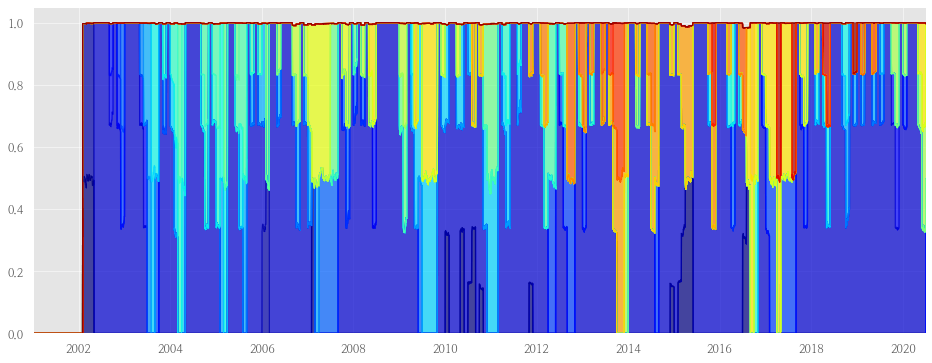

In [15]:
r.get_security_weights('kbase2').plot.area(stacked=True, alpha=0.7, legend=False, cmap='jet', figsize=(16,6));

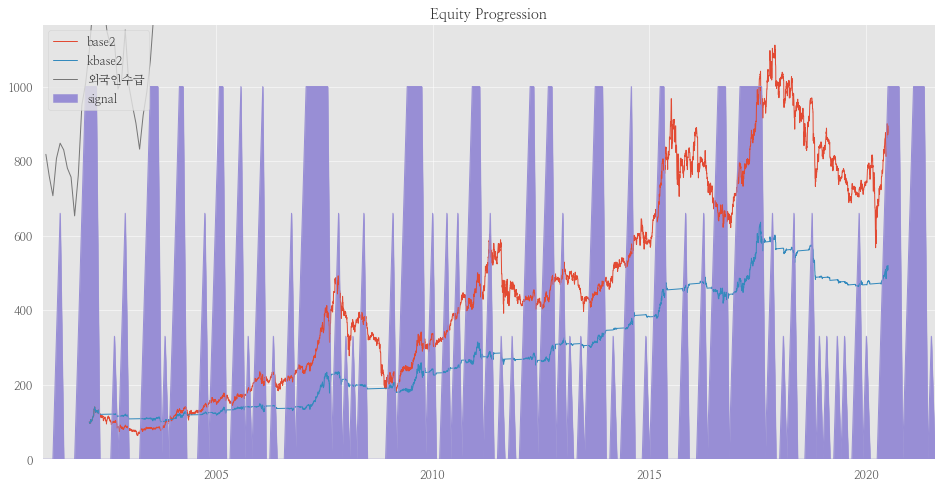

In [17]:
ax = r.plot(figsize=(16,8));
(target_weights['base2']*1000).plot.area(ax=ax, label='signal');
(외국인수급['kospi']*10).plot(ax=ax, label='외국인수급');
plt.legend(loc="upper left");

In [ ]:
r.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));

In [ ]:
# bt_kbase2.positions.to_csv('한국ID2상대모멘텀_포지션.csv')